In [10]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [8]:
import pandas as pd
import numpy as np

import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import nltk
import contractions
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re
import string

In [143]:
# !pip install pyLDAvis
# !pip install spacy
# nltk.download('stopwords')
# nltk.download('punkt')
# !pip install contractions


In [9]:
words_to_remove = ['result', 'image', 'task', 'figure', 'also', 'based', 'one', 'two', 'three', 'set'
                  , 'size', 'use', 'using', 'used', 'arxiv', 'page', 'table', 'proceeding', 'human', 'dataset', 'datasets'
                  , 'ieee', 'number', 'work', 'information', 'preference']
stop_words.extend(words_to_remove)


In [11]:
def _preprocess_text( text):
    
    '''preprocess text before use it in topic modeling'''

    # translate contractions
    text = contractions.fix(text.lower())
    
    # tokenization
    words = nltk.word_tokenize(text)
    
    # keep alpha-numeric terms and remove stop words
    new_words= [word for word in words if word.isalnum() and not word.lower() in stop_words]
    text = ' '.join([word for word in new_words ])

    # remove some patterns
    regex = [r'\d+', r'\S*@\S*\s?', r'^https?:\/\/.*[\r\n]*', 
             r'<\w*>', r'\s[a-z]{,2}\s',  r'\s\d?[a-z]{1,2}\s', 
             r'\s+', r'∀',r'θ', r'∈', r'Ω', r'σ',r'Σ', r'λ', r'φ',r'α', r'ø']
    for r in regex:
        text = re.sub(r, ' ', str(text)) 
        
    # remove punctuation
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    
    return text

# Papers Data Loading ...

In [12]:

data=[]
for file in os.listdir('data/'):
    data.append({
    'text': open('data/{}'.format(file), errors='ignore', encoding='utf-16').read()
    })
    

In [13]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(1064, 1)


,text
0,Linguistic Input Features Improve Neural Machi...
1,Multiresolution Recurrent Neural Networks: An ...
2,From Captions to Visual Concepts and Back\n\nH...
3,Deep Reinforcement Learning for List-wise Reco...
4,Sentiment Classiﬁcation using Document Embeddi...


# Preprocess Papers Text ...

In [14]:
df['text'] = df['text'].apply(_preprocess_text)

In [15]:
print(df.shape)
df.head()

(1064, 1)


,text
0,linguistic input features improve neural machi...
1,multiresolution recurrent neural networks appl...
2,captions visual concepts back hao fang saurabh...
3,deep reinforcement learning recommendations xi...
4,sentiment classiﬁcation document embeddings tr...


# EDA 

### Number of words in papers (Min, Avg, Max)

In [16]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print('Min number of words: ', df['word_count'].min())
print('Avg number of words: ', df['word_count'].mean())
print('Max number of words: ', df['word_count'].max())

Min number of words:  455
Avg number of words:  3427.5065789473683
Max number of words:  32462


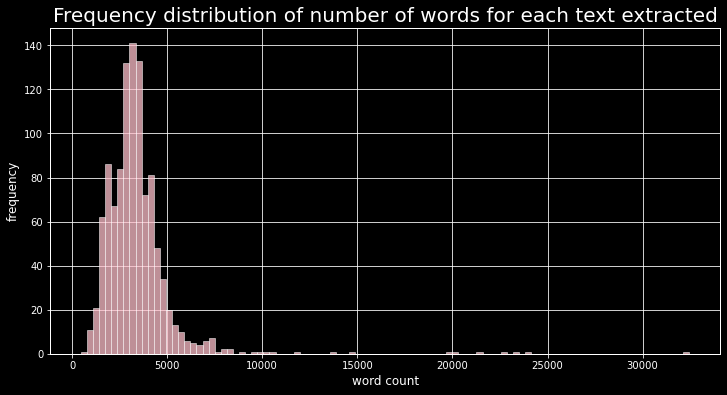

In [19]:
plt.style.use('ggplot')
with plt.style.context('dark_background'):
    plt.figure(figsize=(12,6))
    sns.histplot(df['word_count'],kde = False,color="pink", bins = 100)
    plt.xlabel('word count')
    plt.ylabel('frequency')
    plt.title("Frequency distribution of number of words for each text extracted", size=20)
plt.show()

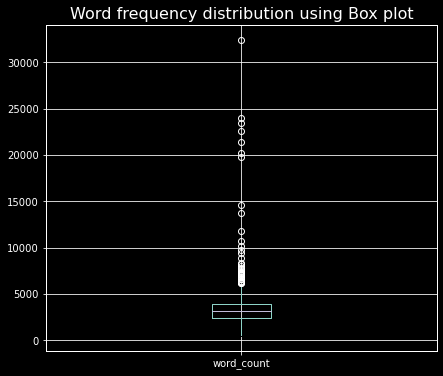

In [20]:
with plt.style.context('dark_background'):
    plt.figure(figsize = (7,6))
    df['word_count'].plot(kind="box")
    plt.title("Word frequency distribution using Box plot", size = 16)
plt.show()

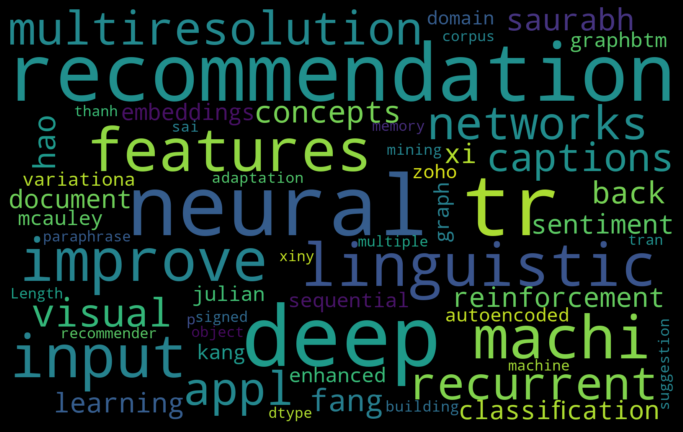

In [22]:

from wordcloud import WordCloud, STOPWORDS

papers_text = df['text']
papers_string = []
for pt in papers_text:
    papers_string.append(pt)
papers_string = pd.Series(papers_string).map(str)
papers_string = str(papers_string)

with plt.style.context('dark_background'):
    wordcloud = WordCloud(width=1600, height=1000,max_font_size=200).generate(papers_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
plt.show()

# <hr>

# Topic Modeling Section

In [23]:
# nltk.download('wordnet')

In [24]:

import spacy

from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

from sklearn.manifold import TSNE

import gensim
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.coherencemodel import CoherenceModel

from collections import Counter
from matplotlib.ticker import FuncFormatter

/Users/ghadeeraboalrob/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Text Preprocessing Phases

In [25]:
def tokenize(text):
    '''a function which convert a given text into tokens'''
    return nltk.word_tokenize(text)

def lematize(tokens):    
    '''a function which lemmatize each word in the given text'''
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(text) 

def lematize_tolist(tokens):    
    '''a function which lemmatize each word in the given text'''
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in tokens]
    return text 

In [26]:
df['tokens'] = df['text'].apply(tokenize)
df['lemmatized_text'] = df['tokens'].apply(lematize)
df['lemmatized_list'] = df['tokens'].apply(lematize_tolist)
df.head()

,text,word_count,tokens,lemmatized_text,lemmatized_list
0,linguistic input features improve neural machi...,2821,"[linguistic, input, features, improve, neural,...",linguistic input feature improve neural machin...,"[linguistic, input, feature, improve, neural, ..."
1,multiresolution recurrent neural networks appl...,6008,"[multiresolution, recurrent, neural, networks,...",multiresolution recurrent neural network appli...,"[multiresolution, recurrent, neural, network, ..."
2,captions visual concepts back hao fang saurabh...,3283,"[captions, visual, concepts, back, hao, fang, ...",caption visual concept back hao fang saurabh g...,"[caption, visual, concept, back, hao, fang, sa..."
3,deep reinforcement learning recommendations xi...,3957,"[deep, reinforcement, learning, recommendation...",deep reinforcement learning recommendation xia...,"[deep, reinforcement, learning, recommendation..."
4,sentiment classiﬁcation document embeddings tr...,2342,"[sentiment, classiﬁcation, document, embedding...",sentiment classiﬁcation document embeddings tr...,"[sentiment, classiﬁcation, document, embedding..."


# Word Embedding Generation using Word2Vec model from Gensim

In [27]:
tokens = df['lemmatized_list']

In [28]:
w2v_model = Word2Vec(tokens,
                     min_count=300, # min frequency of a word, ignore words with frequency lower than min_count
                     window=10, # maximum distance between the current and predicted word within a sentence
                     vector_size=256, # Dimensionality of the result vector
                     alpha=0.03, # learning rate
                     min_alpha=0.0006, # learning rate will drop during training linearly by min_alpha 
                     workers = 4, # worker threads to train the model
                     seed = 42 # random number generator
                    )


In [29]:
# vector of a word 
v1 = w2v_model.wv['reinforcement']
print(len(v1))
v1

256


array([ 1.1727808e+00,  4.6367291e-01,  1.3542094e+00,  1.3076133e+00,
        1.5916395e+00, -9.8216124e-02,  1.6370207e+00, -6.0970461e-01,
        4.7425348e-01,  5.8668226e-01, -1.1593554e+00, -9.8102850e-01,
        7.5314850e-01, -8.4983222e-02,  1.1229399e+00,  1.5487343e+00,
        8.6228049e-01, -8.4088677e-01,  3.1175232e-01, -1.4338859e-02,
        8.3394960e-02, -2.4075498e-01,  1.0427493e+00, -8.7162060e-01,
       -1.0078955e+00,  5.6380078e-02, -8.7418962e-01,  5.2144104e-01,
        3.3193693e-01,  2.8303576e+00,  1.8365325e+00, -4.7354278e-01,
        6.2529004e-01,  1.6642823e+00, -1.5642743e+00,  3.0017302e+00,
        5.3334796e-01,  1.8189203e+00,  1.2126571e+00,  1.2667773e+00,
       -7.8272957e-01, -2.5648853e-01,  1.0900323e+00,  2.3611566e-02,
        1.0032077e+00, -1.2580842e+00, -1.7848383e-01, -3.5888441e-02,
       -5.1838470e-01, -1.3993927e+00, -4.7336179e-01, -4.1106328e-01,
        1.4890002e-02, -1.5159184e+00, -4.1554230e-01, -2.4515960e-01,
      

In [30]:
# words related to e.g. w = reinforcement
w2v_model.wv.most_similar('reinforcement')

[('policy', 0.5794519782066345),
 ('agent', 0.5545083284378052),
 ('reward', 0.5468470454216003),
 ('williams', 0.43900710344314575),
 ('deep', 0.4388872981071472),
 ('machine', 0.4337247908115387),
 ('environment', 0.43235158920288086),
 ('chine', 0.41836050152778625),
 ('critic', 0.406828373670578),
 ('conversational', 0.40549129247665405)]

# Word Embedding Visualization

In [31]:
def plot_TSNE(model, words=None, specific_list=False):
    
    """visualize words of word2vec model as vector in space"""
    
    labels = [] # word
    tokens = [] # word representation as vector
    
    # if we need to plot for specific list of words 
    if specific_list:
        labels = words
        for word in labels:
            tokens.append(model.wv[word]) # add word vector
            labels.append(word) # add word 
    
    else: # plot for all words of word2vec model
        for word in list(model.wv.index_to_key):
            tokens.append(model.wv[word]) # add word vector
            labels.append(word) # add word 
    
    # define TSNE model from sklearn
    tsne_model = TSNE(perplexity=50, # larger dataset need larger value here, but TSNE is insensitive to this parameter
                      n_components=2, # number of dimensions 
                      init='pca', # Initialization of embedding, PCA (dimensionality reduction)
                      n_iter=2000, # iterations for the optimization
                      random_state=23)
    
    # model training / get new vectors (new dimension) for embeddings/ transform input embeddings (dimensionality reduction)
    new_vectors = tsne_model.fit_transform(tokens)

    # plot results
    x = []
    y = []
    for vector in new_vectors:
        x.append(vector[0])
        y.append(vector[1])
        
    plt.figure(figsize=(17, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

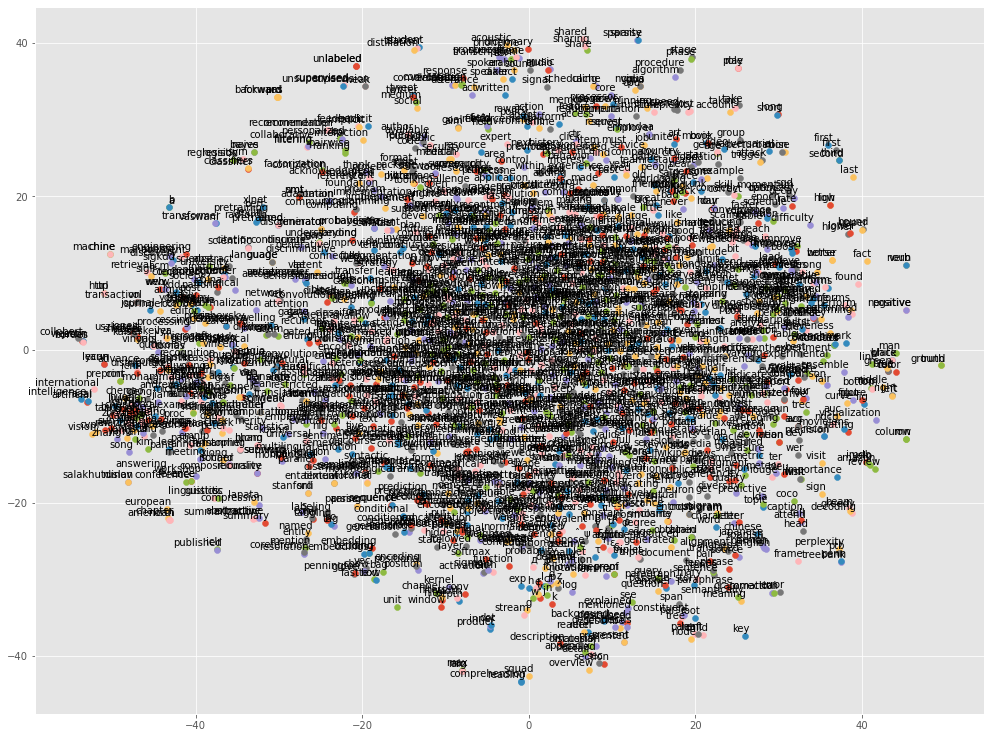

In [32]:
plot_TSNE(w2v_model)

# <hr>

# LDA Model Section

###  Dictionary and doc_term_matrix needed for Topic Modeling

In [33]:
# dictionary and  needed for Topic Modeling
dictionary = corpora.Dictionary(df['lemmatized_list'])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in df['lemmatized_list']]

# LDA Model 

In [34]:
def lda2vec(corpus, id2word, num_topics, random_state,chunksize, passes):
    
    """Build LDA model from Gensim"""
    # corpus : stream of document vectors of shape (num_documents, num_terms)
    # id2word : mapping from word IDs to words. It is used to determine the vocabulary size and topic printing
    # num_topics : number of latent topics to be extracted
    # chunksize : number of documents to be used in each training chunk
    # passes : number of passes through the corpus during training
    
    LDA = gensim.models.ldamodel.LdaModel
    # Build LDA model
    lda_model = LDA(corpus=corpus, id2word=id2word, num_topics=num_topics, 
                    random_state=random_state,chunksize=chunksize, passes=passes)
    return lda_model
    

# Model Coherence Score

In [35]:
def find_coherence_score(model,texts, dictionary, coherence='c_v'):
    """ Judge how good a given topic model is, by detemining how coherent the topics terms are """
    
    # model : LDA model to be evaluated
    # texts : all text words used in topic modeling, tokenized text
    # dictionary : mapping of id word to create corpus
    # coherence :  coherence measure to be used
    
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()

    return coherence_lda

<hr>

# Topic Visualization Techniques

# 1. Word Distribution over Topics

# Topic keywords as Word Cloud

In [266]:
def visualize_topic_keywords(lda_model, num_topics):
    """ show topic keywords as word cloud """
    # lda_model : LDA model used for topic modeling
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(int((num_topics+1)/2), 2, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        if i<num_topics:
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')


# Word Count and Importance of Topic Keywords

In [267]:
from collections import Counter

def visulize_words_importance_for_topic(lda_model, tokens, num_topics):
    """ show word count and importance of topic words per topic"""
    # lda_model : LDA model used for topic modeling
    # tokens : tokenized text in topic modeling
    
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in tokens for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    data = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(int((num_topics+1)/2), 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        if i<num_topics:
            ax.bar(x='word', height="word_count", data=data.loc[data.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
            ax_twin = ax.twinx()
            ax_twin.bar(x='word', height="importance", data=data.loc[data.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
            ax.set_ylabel('Word Count', color=cols[i])
            ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
            ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
            ax.tick_params(axis='y', left=False)
            ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
            ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()

# Transforms the topic model distributions and related corpus data into the data structures needed for the visualization

In [38]:
import pyLDAvis
import pyLDAvis.gensim_models

def pyLDAvis_fun(lda_model, doc_term_matrix, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
    return vis

# 2. Topic Distribution over Documents

In [409]:
def get_dominant_topic_per_document( model, corpus, num_topic=4, index=None):
    
    """ get the dominant topic for each document and return dataframe of documents with dominant topic"""
    # model : lda model for topic modeling
    # corpus : stream of document vectors of shape (num_documents, num_terms)
    # num_topic : number of topics
    # index : if we need to get dominant topics for a specific document
    
    corpus_sel = corpus
    if index is not None:
        corpus_sel = corpus[index:index+1]
    
    dominant_topics = []
    dominant_topics_num=[] # topic number
    dominant_topics_cont=[] # topic contribution
    topic_keywords = [] # topic terms or keywords
    keywords=[]
    
    # get topics keywords once
    words_topic = [model.show_topic(t) for t in range(0,num_topic)]
    for w in words_topic:
        keywords.append(','.join([i[0] for i in w]))
        
    
    
    for i, corp in enumerate(corpus_sel):
        
        # get percentage of contribution for each topic per document
        topic_percs = model[corp]
        # get dominant topic, topic with highest contribution in a document
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0] # tuple (topic, contribution)
        
        dominant_topics_num.append(dominant_topic[0]) # topic number
        dominant_topics_cont.append(dominant_topic[1]) # topic contribution
        topic_keywords.append(keywords[dominant_topic[0]]) # topic terms or keywords
    
    # return a record for specific sample
    if index is not None:
        return {'document':index,'Dominant_topic':dominant_topics_num, 'Topic_Contribution':dominant_topics_cont,'Topic_Keywords':topic_keywords}
    
    # return all samples
    return pd.DataFrame(data={'document':range(0,len(corpus)),'Dominant_topic':dominant_topics_num, 
                              'Topic_Contribution':dominant_topics_cont,'Topic_Keywords':topic_keywords})



def get_topics_contribution_per_document( model, corpus, num_topic=4, index=None):
    
    """ get the dominant topic for each document and return dataframe of documents with corresponding topics"""
    # model : lda model for topic modeling
    # corpus : stream of document vectors of shape (num_documents, num_terms)
    # num_topic : number of topics
    # index : if we need to get topics contribution for a specific document
    
    corpus_sel = corpus
    if index is not None:
        corpus_sel = corpus[index:index+1]
        
    dominant_topics = []
    dominant_topics_num=[] # topic number
    dominant_topics_cont=[] # topic contribution
    topic_keywords = [] # topic terms or keywords
    keywords=[]
    
    # get topics keywords once
    words_topic = [model.show_topic(t) for t in range(0,num_topic)]
    for w in words_topic:
        keywords.append(','.join([i[0] for i in w]))

    
    for i, corp in enumerate(corpus_sel):

        # get percentage of contribution for each topic per document
        topic_percs = model[corp]
        
        # get dominant topic, topic with highest contribution in a document
        # list of tuples, each tuple represents a topic (# tuple (topic, contribution))
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True) 
        
        topics_num = [t[0] for t in dominant_topic]
        topics_cont = [t[1] for t in dominant_topic]
        dominant_topics_num.append(topics_num) # topic number
        dominant_topics_cont.append(topics_cont) # topic contribution
        topic_keywords.append([keywords[i] for i in topics_num]) # topic terms or keywords
        
         
    # return a record for specific sample
    if index is not None:
        # plot dominant topic
        data = pd.DataFrame(data={'t':[t[0] for t in dominant_topic],'c':[t[1] for t in dominant_topic]})
        colors = sns.color_palette('deep')
        plt.pie(data['c'], labels=data['t'],colors = colors, autopct = '%0.0f%%', normalize=True)
        plt.title('Contribution of Topics over Document')
        plt.show()
        return {'document':index,'Dominant_Topics_Contribution':dominant_topic,'Topic_Keywords':topic_keywords }
    
    # return all samples
    df = pd.DataFrame(data={'document':range(0,len(corpus)),'Dominant_topics':dominant_topics_num, 
                            'Topics_Contribution':dominant_topics_cont, 'Topic_Keywords':topic_keywords})
    # explode the result
    return df.set_index(['document']).apply(pd.Series.explode).reset_index()
     




In [410]:
def get_topic_info(contribution_df, dominant_df, df):
    
    """ get topic information : 
    1. Distribution of topic over documents (percentage of each topic in the dataset)
    2. The most representative document for each topic
    3. Distribution of dominant topics over documents
    """
    # contribution_df : df with contribution of each topic in documents
    # df : original df which hold dataset text
    
    # 1. Percentage of each topic in the dataset
    topics_info_df = pd.DataFrame(contribution_df['Dominant_topics'].value_counts()).reset_index()
    topics_info_df.columns=['Dominant_topics', 'num_of_docs']
    topics_info_df['percentage_of_docs'] = topics_info_df['num_of_docs'].apply(lambda x:( x/len(df)))
    topics_info_df = pd.merge(topics_info_df, contribution_df[['Dominant_topics','Topic_Keywords']], on='Dominant_topics').groupby('Dominant_topics').agg(
    {'num_of_docs':'first', 'percentage_of_docs':'first', 'Topic_Keywords':'first'}).reset_index()
    
    # plot Distribution of Topics over Documents
    # 80% of documents talk about topic 0
    # Bar chart: a document can have a number of topics (represent a document by several topics)
    f, ax = plt.subplots(figsize = (15,6))
    sns.barplot(data=topics_info_df, x='Dominant_topics', y='percentage_of_docs', hue='Topic_Keywords', ax=ax)
    plt.title('Distribution of Topics over Documents (represent a document by several topics)')
    plt.ylim([0,1])
    plt.show()
    
    # 2. The most representative document for each topic
    contribution_df = contribution_df.sort_values('Topics_Contribution')
    rep_df=contribution_df.groupby('Dominant_topics').agg({'document':'last' ,'Topics_Contribution':'max', 'Topic_Keywords':'first'}).reset_index()
    rep_df['document_text'] = rep_df['document'].apply(lambda x : df[df.index==x]['lemmatized_text'].item())
    
    # 3. Distribution of dominant topics over documents (more specific)
    # e.g. topic 0 is the dominant topic for 35% of document 
    # Pie chart: the percentage of each topic as a dominant topic in the dataset (represent a document by only one topic *the dominant*)
    data = np.multiply(np.divide(dominant_df['Dominant_topic'].value_counts(),len(df)), 100)
    colors = sns.color_palette('deep')
    plt.pie(data, labels=data.index,colors = colors, autopct = '%0.0f%%')
    plt.title('Distribution of Dominant Topics over Documents (represent a document by only one topic *the dominant*)')
    plt.show()
    

    return topics_info_df, rep_df
    

<hr>

# LDA - Extract 5 latent topics 

### Create Model

In [39]:
# LDA with number of Topics = 5
num_topics = 5

lda_5topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)


### print Topics

In [40]:
lda_5topic.print_topics()

[(0,
  '0.019*"word" + 0.017*"model" + 0.011*"sentence" + 0.009*"text" + 0.006*"method" + 0.006*"vector" + 0.006*"representation" + 0.006*"document" + 0.006*"learning" + 0.005*"page"'),
 (1,
  '0.023*"model" + 0.013*"network" + 0.011*"neural" + 0.010*"training" + 0.009*"learning" + 0.008*"layer" + 0.007*"sequence" + 0.006*"input" + 0.004*"output" + 0.004*"attention"'),
 (2,
  '0.013*"user" + 0.011*"model" + 0.009*"item" + 0.007*"data" + 0.007*"system" + 0.007*"learning" + 0.007*"method" + 0.006*"feature" + 0.006*"recommendation" + 0.006*"algorithm"'),
 (3,
  '0.014*"question" + 0.011*"entity" + 0.009*"model" + 0.009*"bert" + 0.009*"language" + 0.008*"answer" + 0.005*"token" + 0.005*"task" + 0.004*"data" + 0.004*"relation"'),
 (4,
  '0.018*"language" + 0.016*"word" + 0.013*"model" + 0.013*"translation" + 0.012*"system" + 0.010*"speech" + 0.008*"data" + 0.007*"training" + 0.007*"corpus" + 0.006*"recognition"')]

### Model evaluation - find Coherence Score

In [41]:
### Model evaluation - find Coherence Score
coherence_score_5 = find_coherence_score(model=lda_5topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_5)


Coherence Score:  0.396264810507097


## Visualization for 5 topics

### Topic keywords as Word Cloud

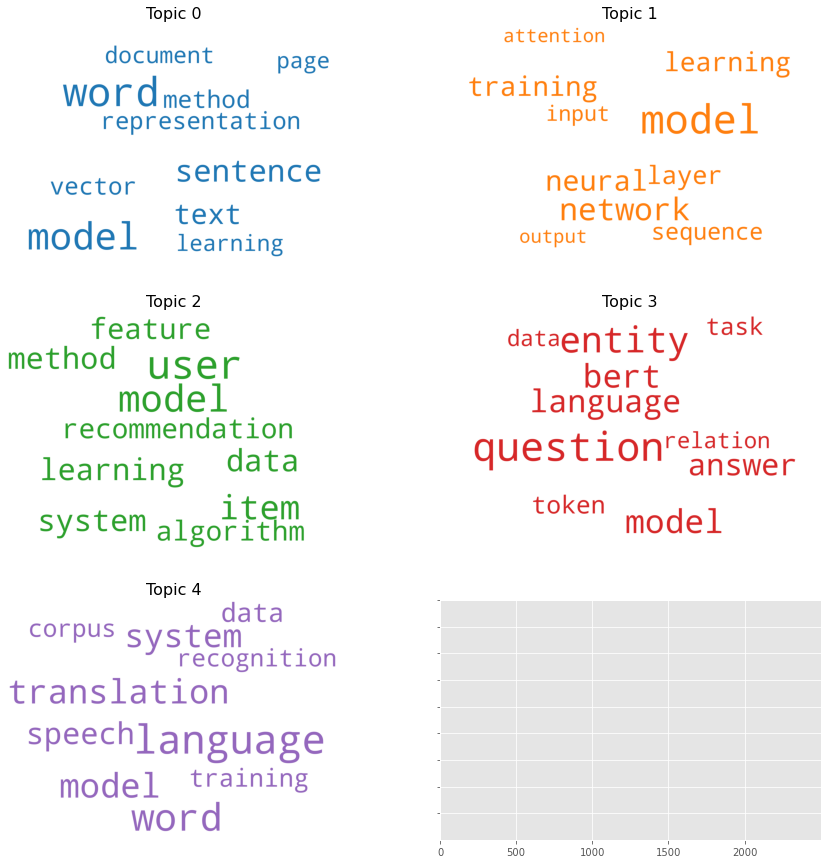

In [268]:
visualize_topic_keywords(lda_5topic, 5)

### Word Count and Importance of Topic Keywords

<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic

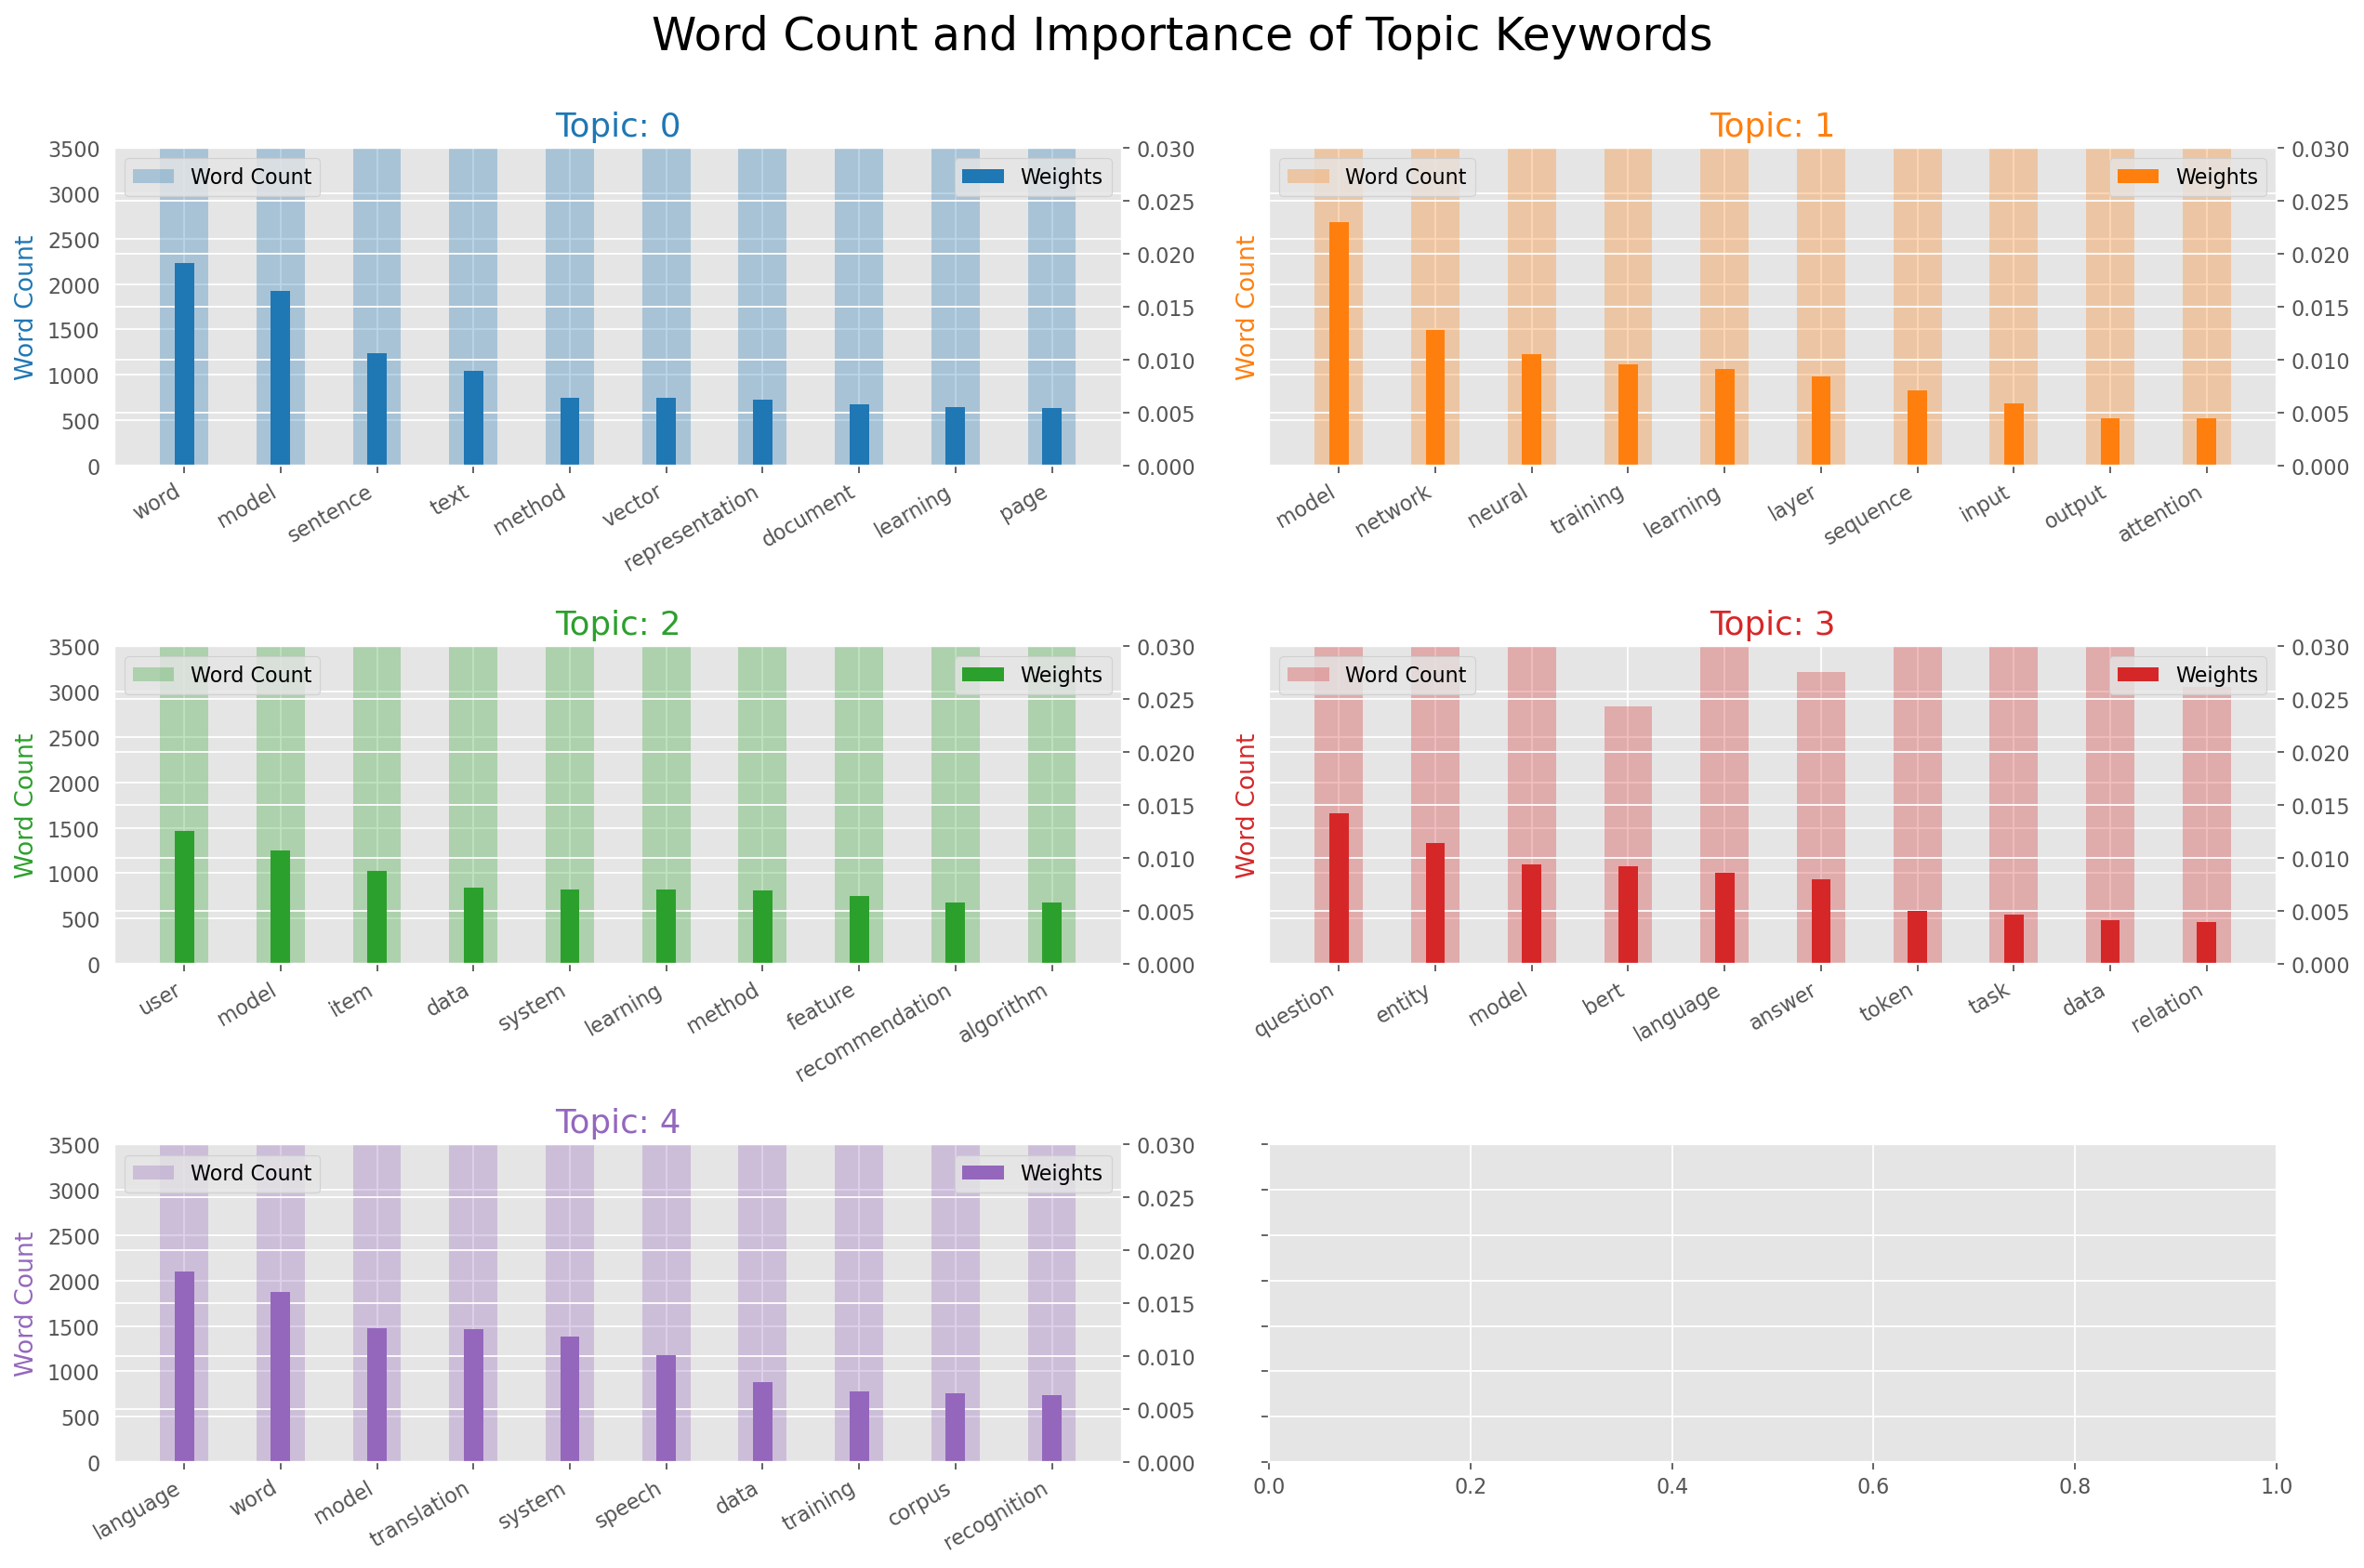

In [269]:
visulize_words_importance_for_topic(lda_5topic, df['lemmatized_list'], 5)

### Topics, terms distribution

In [49]:
pyLDAvis_fun(lda_5topic, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.095818  0.035877       1        1  29.455353
0      0.015183 -0.005134       2        1  28.713407
2      0.084962  0.075550       3        1  21.791155
4     -0.010224 -0.168198       4        1  11.621974
3     -0.185738  0.061906       5        1   8.418111, topic_info=                Term          Freq         Total Category  logprob  loglift
945             word  29382.000000  29382.000000  Default  30.0000  30.0000
458         language  20141.000000  20141.000000  Default  29.0000  29.0000
2487            user  10377.000000  10377.000000  Default  28.0000  28.0000
883      translation   9057.000000   9057.000000  Default  27.0000  27.0000
677         question   5617.000000   5617.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
740            score    769.925846   7884.210606   Topic5  -5.9883   0.1485
705   representation    784.143968  11652.453669   Topic5  -5.9700  -0.2239
174           corpus    689.826747   5976.836358   Topic5  -6.0982   0.3156
856             test    702.095939   8070.049483   Topic5  -6.0805   0.0329
343            given    681.829531   6123.673127   Topic5  -6.1098   0.2796

[436 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3197       1  0.019856        acm
3197       2  0.144536        acm
3197       3  0.775825        acm
3197       4  0.008176        acm
3197       5  0.051683        acm
...      ...       ...        ...
6213       3  0.998627          д
38034      3  0.994974          ℓ
64850      2  0.990978          刑
69160      3  0.994634          푖
3194       5  0.993116  ﬁnetuning

[928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

## Finding Topics in each Document

In [399]:
# topics contribution in each document
contribution_df = get_topics_contribution_per_document(lda_5topic, doc_term_matrix, 5)
contribution_df


,document,Dominant_topics,Topics_Contribution,Topic_Keywords
0,0,4,0.73918,"language,word,model,translation,system,speech,..."
1,0,0,0.171287,"word,model,sentence,text,method,vector,represe..."
2,0,1,0.089387,"model,network,neural,training,learning,layer,s..."
3,1,0,0.537528,"word,model,sentence,text,method,vector,represe..."
4,1,1,0.255284,"model,network,neural,training,learning,layer,s..."
...,...,...,...,...
3263,1062,4,0.538116,"language,word,model,translation,system,speech,..."
3264,1062,0,0.373193,"word,model,sentence,text,method,vector,represe..."
3265,1062,3,0.088501,"question,entity,model,bert,language,answer,tok..."
3266,1063,2,0.936733,"user,model,item,data,system,learning,method,fe..."


## The most dominant Topic in each Document

In [400]:
dominant_df = get_dominant_topic_per_document(lda_5topic, doc_term_matrix, 5)
dominant_df

,document,Dominant_topic,Topic_Contribution,Topic_Keywords
0,0,4,0.739187,"language,word,model,translation,system,speech,..."
1,1,0,0.537532,"word,model,sentence,text,method,vector,represe..."
2,2,0,0.546295,"word,model,sentence,text,method,vector,represe..."
3,3,2,0.785107,"user,model,item,data,system,learning,method,fe..."
4,4,0,0.750467,"word,model,sentence,text,method,vector,represe..."
...,...,...,...,...
1059,1059,2,0.646222,"user,model,item,data,system,learning,method,fe..."
1060,1060,2,0.435042,"user,model,item,data,system,learning,method,fe..."
1061,1061,0,0.916777,"word,model,sentence,text,method,vector,represe..."
1062,1062,4,0.538116,"language,word,model,translation,system,speech,..."


## Distribution of Topics over Documents

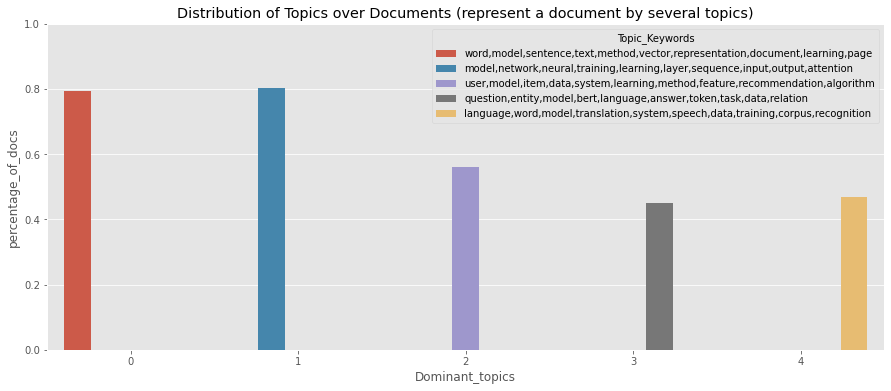

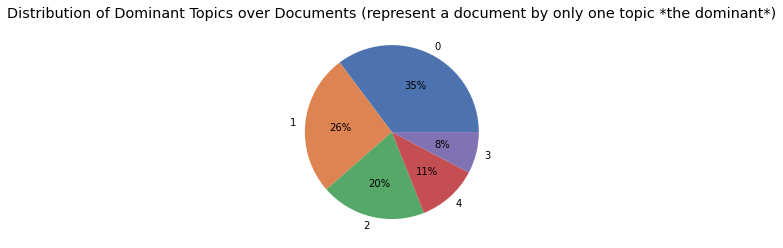

In [408]:
topics_info_df, rep_df=get_topic_info(contribution_df, dominant_df, df)
# Percentage of each topics in the dataset 

# Bar chart: a document can have a number of topics (represent a document by several topics)

# Pie chart: the percentage of each topic as a dominant topic in the dataset (represent a document by only one topic *the dominant*)

In [402]:
# a document can have a number of topics (represent a document by several topics)
# number and percentage of documents for each topic
topics_info_df

,Dominant_topics,num_of_docs,percentage_of_docs,Topic_Keywords
0,0,843,0.792293,"word,model,sentence,text,method,vector,represe..."
1,1,853,0.801692,"model,network,neural,training,learning,layer,s..."
2,2,596,0.560150,"user,model,item,data,system,learning,method,fe..."
3,3,478,0.449248,"question,entity,model,bert,language,answer,tok..."
4,4,498,0.468045,"language,word,model,translation,system,speech,..."


## The most representative text/document for each topic

In [403]:
rep_df

,Dominant_topics,document,Topics_Contribution,Topic_Keywords,document_text
0,0,356,0.999757,"word,model,sentence,text,method,vector,represe...",projecting embeddings domain adaptation joint ...
1,1,732,0.999826,"model,network,neural,training,learning,layer,s...",published conference paper iclr agging nferenc...
2,2,577,0.999814,"user,model,item,data,system,learning,method,fe...",sample complexity online collaborative filteri...
3,3,1000,0.944035,"question,entity,model,bert,language,answer,tok...",published conference paper iclr oarse grain in...
4,4,1041,0.999800,"language,word,model,translation,system,speech,...",evaluating phonemic transcription tonal langua...


# Contribution of Topics over a specific Document

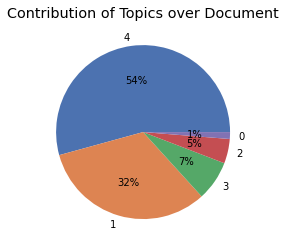

{'document': 90,
 'Dominant_Topics_Contribution': [(4, 0.54270524),
  (1, 0.32483938),
  (3, 0.074220024),
  (2, 0.045546032),
  (0, 0.012689313)],
 'Topic_Keywords': [['language,word,model,translation,system,speech,data,training,corpus,recognition',
   'model,network,neural,training,learning,layer,sequence,input,output,attention',
   'question,entity,model,bert,language,answer,token,task,data,relation',
   'user,model,item,data,system,learning,method,feature,recommendation,algorithm',
   'word,model,sentence,text,method,vector,representation,document,learning,page']]}

In [411]:
# get topics contribution percentage for the 90th document 
get_topics_contribution_per_document(lda_5topic, doc_term_matrix, 5, 90)

# <hr>

# LDA - Extract 4 latent topics

### Create Model

In [42]:
# LDA with number of Topics = 4
num_topics = 4

lda_4topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)



### print Topics

In [44]:
lda_4topic.print_topics()

[(0,
  '0.023*"word" + 0.015*"model" + 0.012*"language" + 0.008*"sentence" + 0.006*"system" + 0.006*"data" + 0.006*"vector" + 0.006*"training" + 0.005*"text" + 0.005*"feature"'),
 (1,
  '0.023*"model" + 0.012*"network" + 0.010*"neural" + 0.009*"training" + 0.009*"learning" + 0.008*"layer" + 0.007*"sequence" + 0.006*"input" + 0.005*"attention" + 0.004*"output"'),
 (2,
  '0.012*"user" + 0.011*"model" + 0.008*"item" + 0.007*"learning" + 0.007*"data" + 0.007*"method" + 0.007*"system" + 0.007*"feature" + 0.006*"algorithm" + 0.005*"recommendation"'),
 (3,
  '0.012*"model" + 0.008*"question" + 0.007*"text" + 0.006*"entity" + 0.006*"language" + 0.006*"sentence" + 0.005*"document" + 0.005*"bert" + 0.005*"word" + 0.004*"answer"')]

### Model evaluation - find Coherence Score

In [45]:
### Model evaluation - find Coherence Score
coherence_score_4 = find_coherence_score(model=lda_4topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_4)


Coherence Score:  0.371674152960205


## Visualization for 4 topics

### Topic keywords as Word Cloud

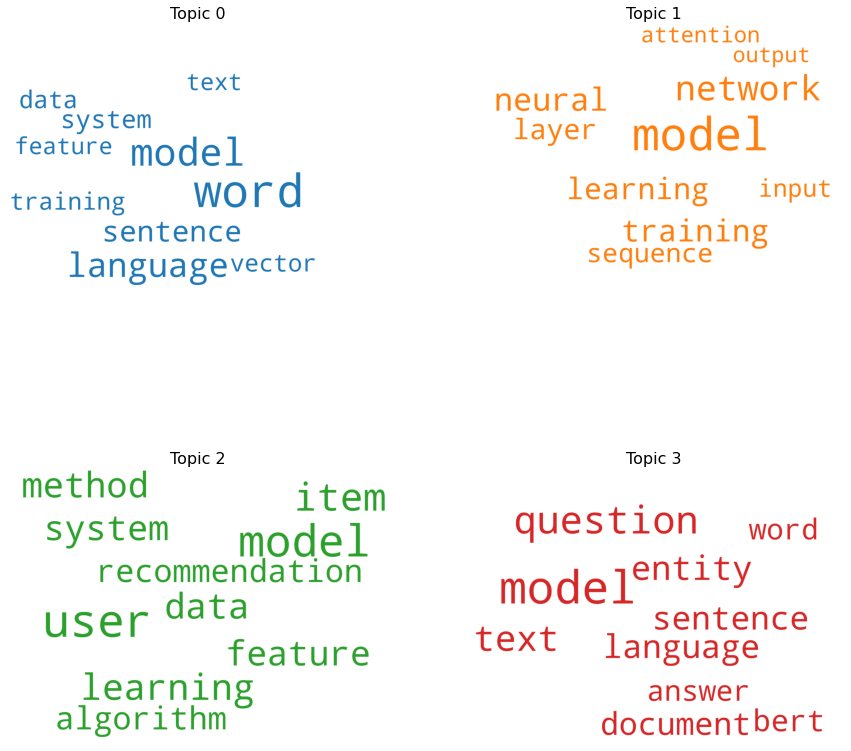

In [270]:
visualize_topic_keywords(lda_4topic, 4)

### Word Count and Importance of Topic Keywords

<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-267-22ade119c3e5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.loc[data.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


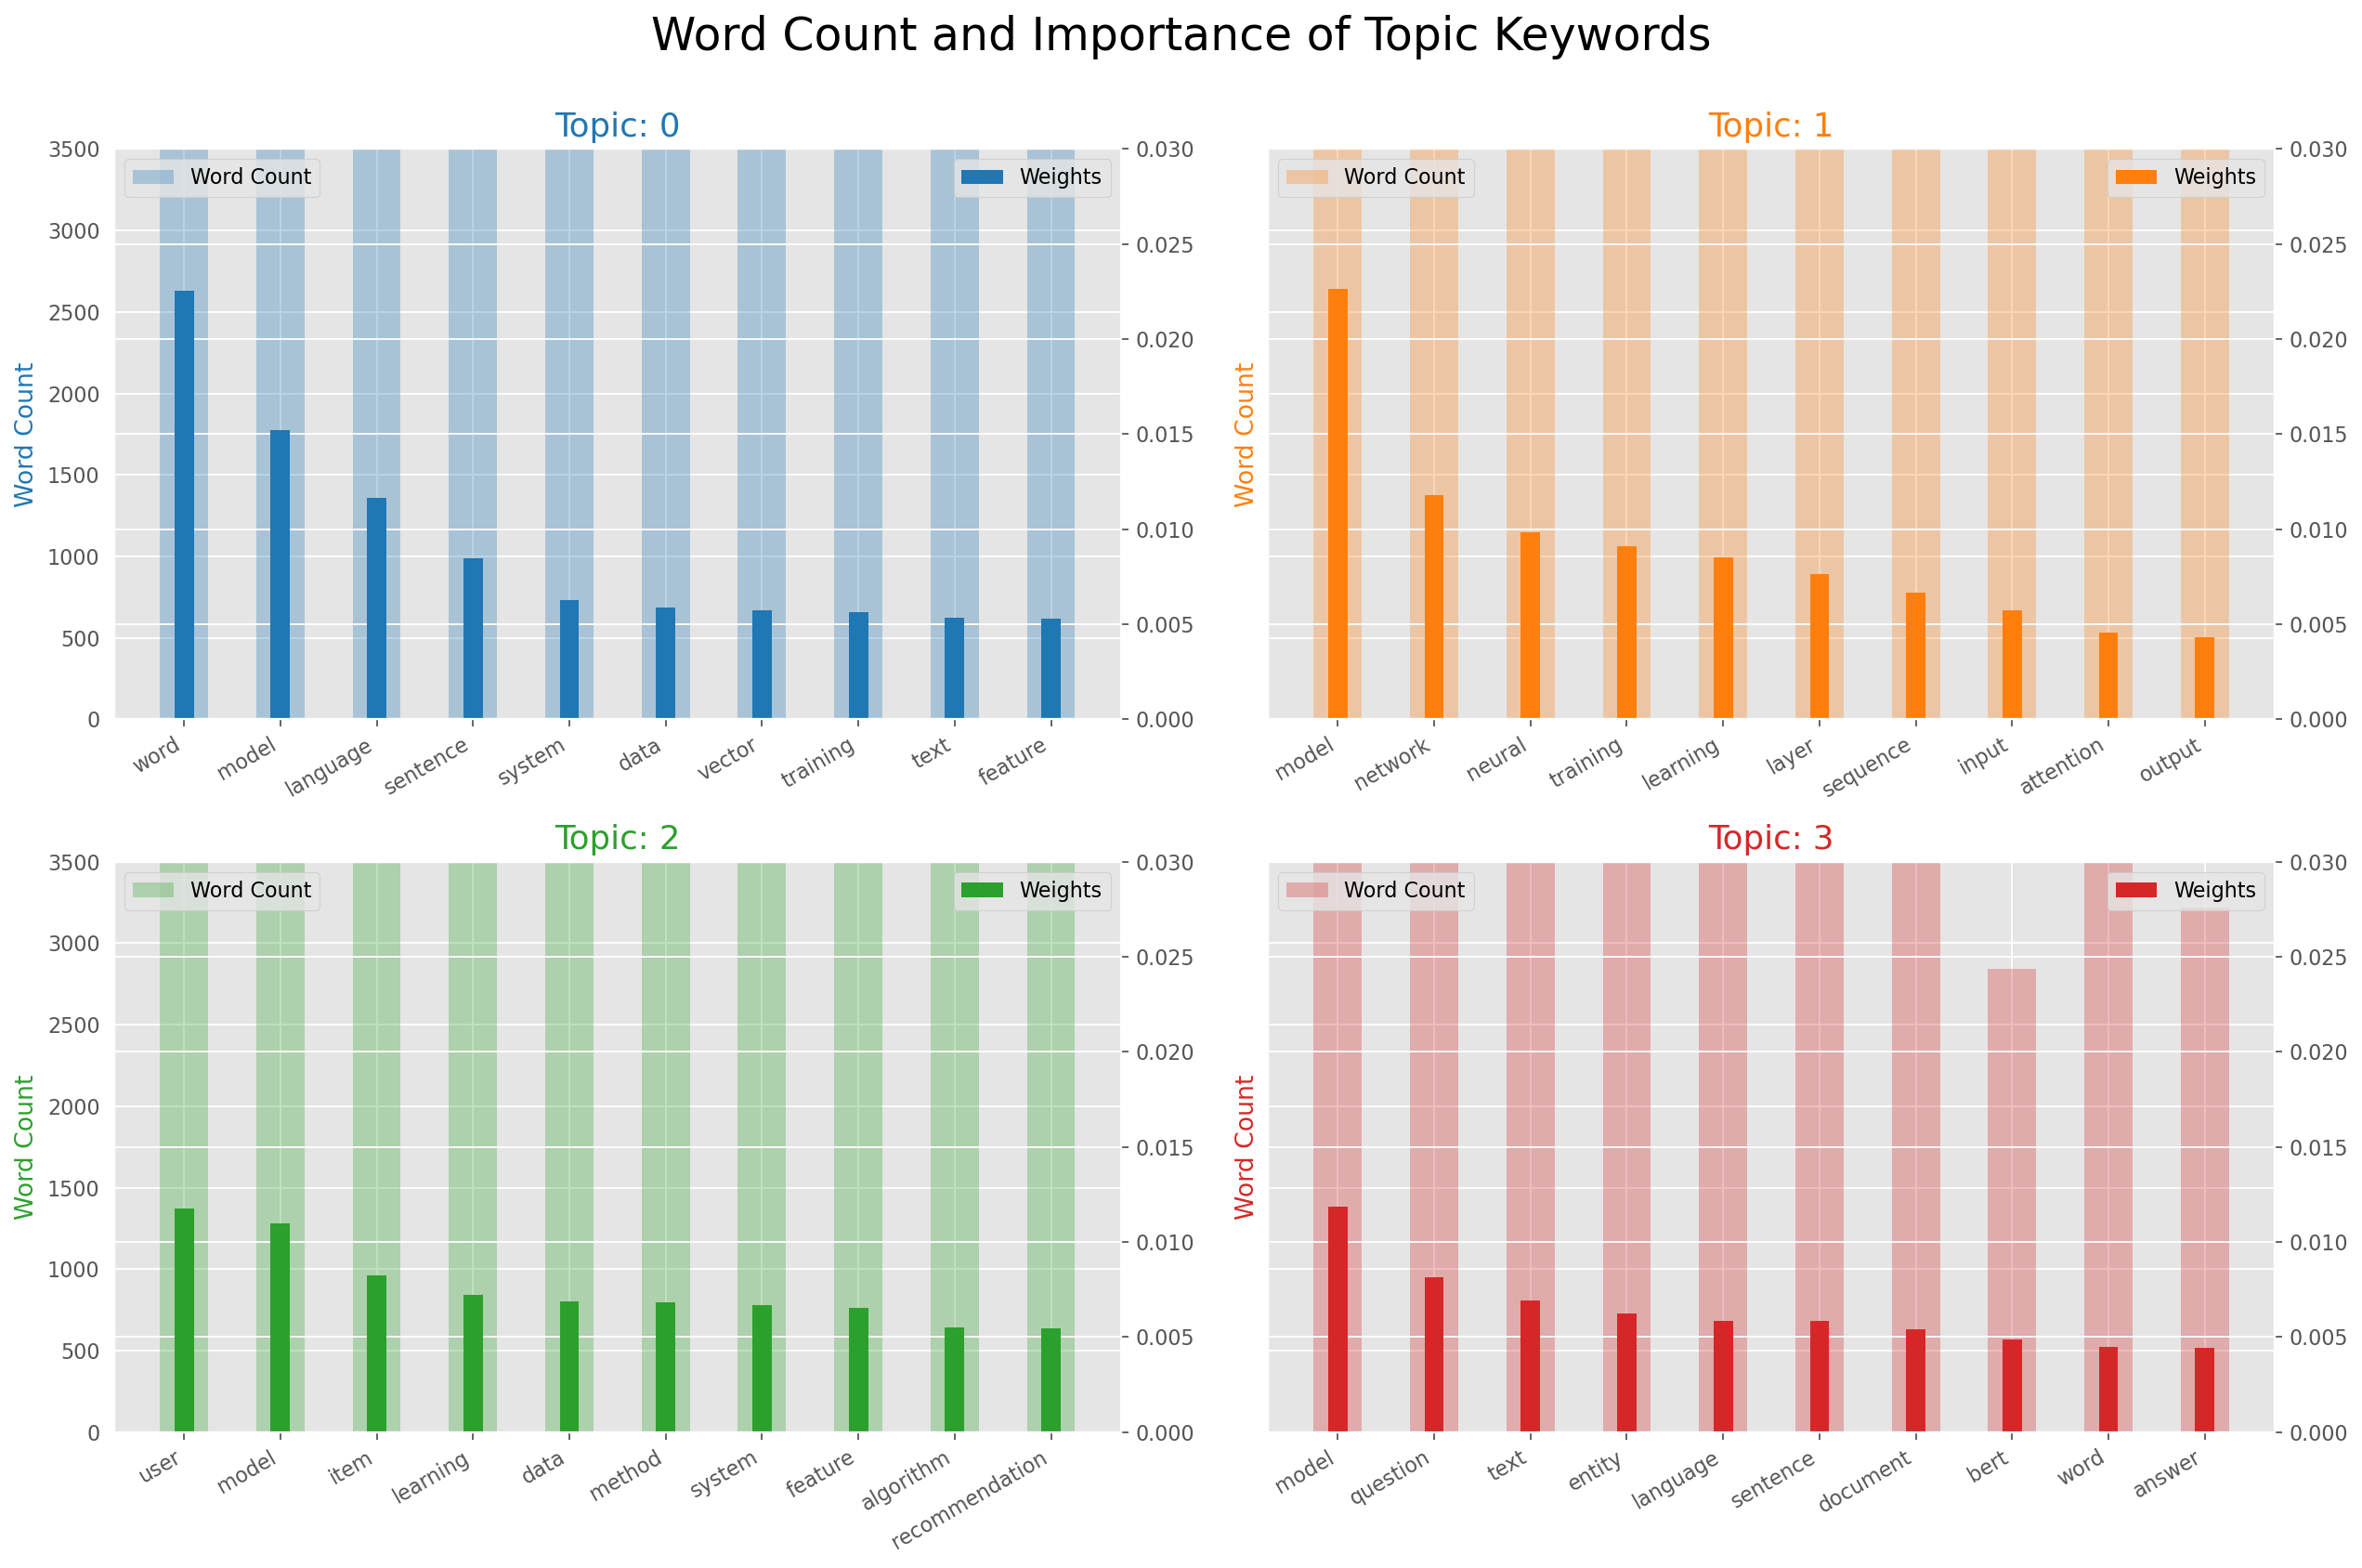

In [271]:
visulize_words_importance_for_topic(lda_4topic, df['lemmatized_list'], 4)

### Topics, terms distribution

In [52]:
pyLDAvis_fun(lda_4topic, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.089556 -0.063453       1        1  32.061409
0     -0.029654 -0.069129       2        1  28.002189
2      0.076891  0.101875       3        1  23.466425
3     -0.136793  0.030707       4        1  16.469977, topic_info=                Term          Freq         Total Category  logprob  loglift
945             word  29175.000000  29175.000000  Default  30.0000  30.0000
2487            user  10497.000000  10497.000000  Default  29.0000  29.0000
3437            item   7085.000000   7085.000000  Default  28.0000  28.0000
677         question   5772.000000   5772.000000  Default  27.0000  27.0000
458         language  20370.000000  20370.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
705   representation   1931.053225  11508.040991   Topic4  -5.7399   0.0187
719           result   1956.539775  12839.251544   Topic4  -5.7268  -0.0777
831           system   1972.945223  15517.717447   Topic4  -5.7185  -0.2588
658       proceeding   1677.230278   9184.837099   Topic4  -5.8808   0.1032
473         learning   1850.510741  22103.859506   Topic4  -5.7825  -0.6767

[368 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4469       1  0.208495  abstractive
4469       2  0.032854  abstractive
4469       4  0.758163  abstractive
3197       1  0.027319          acm
3197       2  0.065682          acm
...      ...       ...          ...
6213       3  0.998906            д
38034      3  0.994770            ℓ
69160      3  0.995290            푖
69174      3  0.994124            푣
3194       4  0.994162    ﬁnetuning

[688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

In [ ]:
get_dominant_topic_per_document(lda_4topic, doc_term_matrix, 4)


In [ ]:
get_topics_contribution_per_document(lda_4topic, doc_term_matrix, 4)

# End of notebook

# <hr>

In [248]:
### Model evaluation - find Coherence Score
num_topics = 3

lda_3topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)



coherence_score_3 = find_coherence_score(model=lda_3topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_3)


Coherence Score:  0.35468107842650703


In [249]:
### Model evaluation - find Coherence Score
num_topics = 6

lda_6topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)



coherence_score_6 = find_coherence_score(model=lda_6topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_6)


Coherence Score:  0.4043832373441468


In [275]:
### Model evaluation - find Coherence Score
num_topics = 7

lda_7topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)



coherence_score_7 = find_coherence_score(model=lda_7topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_7)


Coherence Score:  0.43129633508491755


In [250]:
### Model evaluation - find Coherence Score
num_topics = 8

lda_8topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)



coherence_score_8 = find_coherence_score(model=lda_8topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_8)


Coherence Score:  0.41312004389304213


In [251]:
### Model evaluation - find Coherence Score
num_topics = 10

lda_10topic = lda2vec(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, 
                     random_state=100, chunksize=200, passes=100)



coherence_score_10 = find_coherence_score(model=lda_10topic,
    texts=df['lemmatized_list'], dictionary=dictionary, coherence='c_v')

print('\nCoherence Score: ',coherence_score_10)


Coherence Score:  0.44903659814553276


In [371]:
score_df = pd.DataFrame(data={'model':['3-Topic_lda', '4-Topic_lda', '5-Topic_lda', '6-Topic_lda', '7-Topic_lda','8-Topic_lda', '10-Topic_lda'], 
                              'coherence_score':[coherence_score_3, coherence_score_4, coherence_score_5, coherence_score_6, 
                                                 coherence_score_7, coherence_score_8, coherence_score_10], 
                             'perplexity':[m.log_perplexity(doc_term_matrix) for m in [ lda_3topic, lda_4topic, lda_5topic, 
                                                                                       lda_6topic, lda_7topic, lda_8topic, lda_10topic]]})
score_df.to_excel('lda_scores.xlsx', index=False)
score_df

,model,coherence_score,perplexity
0,3-Topic_lda,0.354681,-8.194812
1,4-Topic_lda,0.371674,-8.173316
2,5-Topic_lda,0.396265,-8.151588
3,6-Topic_lda,0.404383,-8.151735
4,7-Topic_lda,0.431296,-8.175349
5,8-Topic_lda,0.413120,-8.216081
6,10-Topic_lda,0.449037,-8.337915


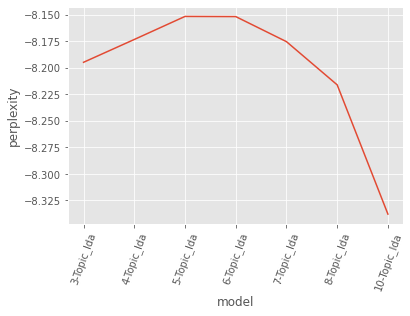

In [370]:
sns.lineplot(x='model', y='perplexity', data=score_df)
plt.xticks(rotation=70)
plt.show()

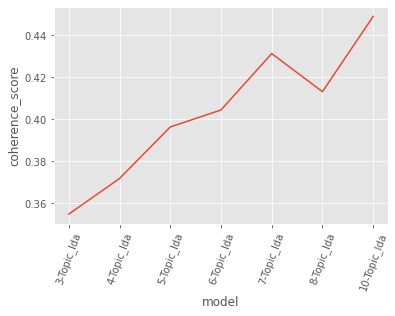

In [277]:
sns.lineplot(x='model', y='coherence_score', data=score_df)
plt.xticks(rotation=70)
plt.show()

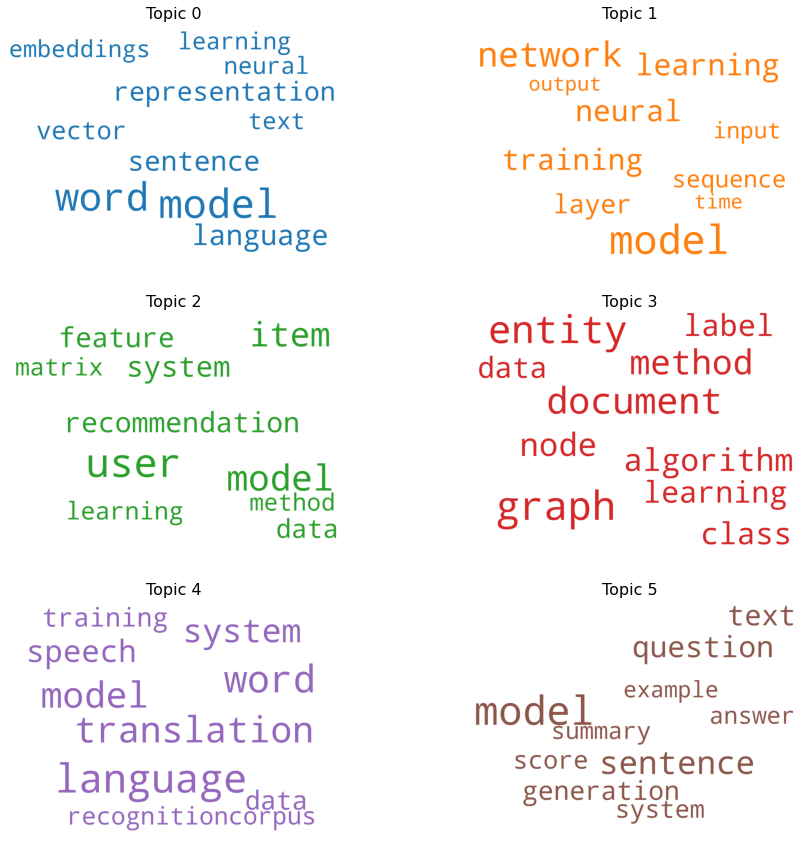

In [272]:
visualize_topic_keywords(lda_6topic, 6)

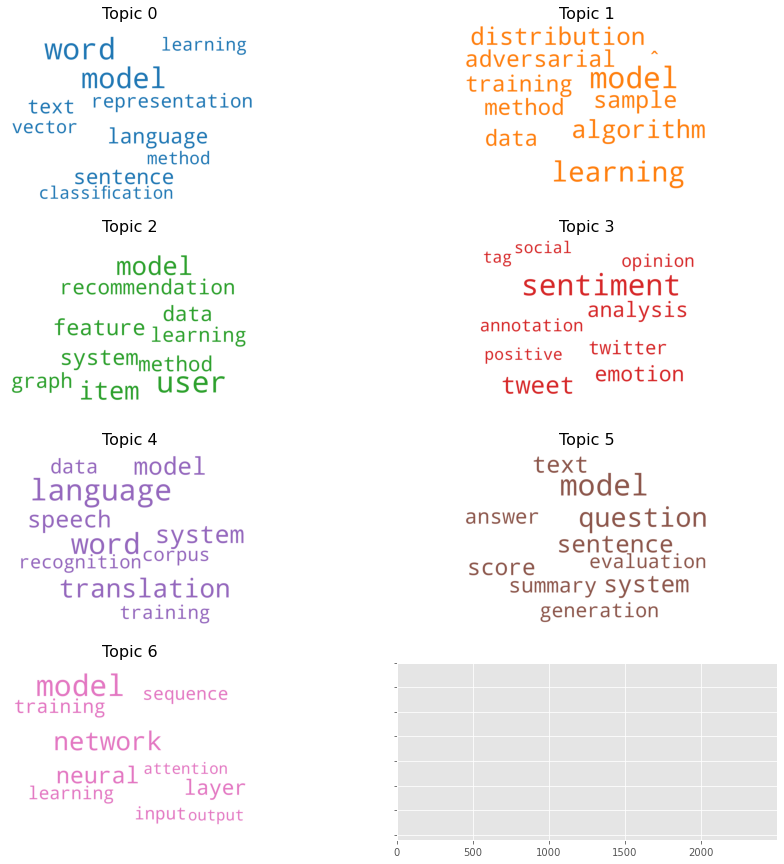

In [278]:
visualize_topic_keywords(lda_7topic, 7)

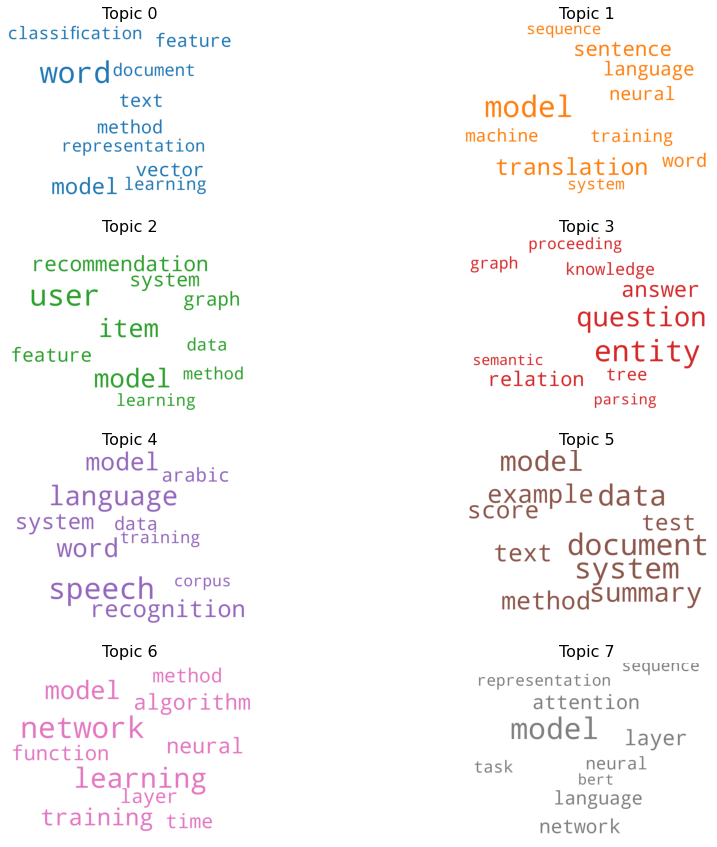

In [273]:
visualize_topic_keywords(lda_8topic, 8)

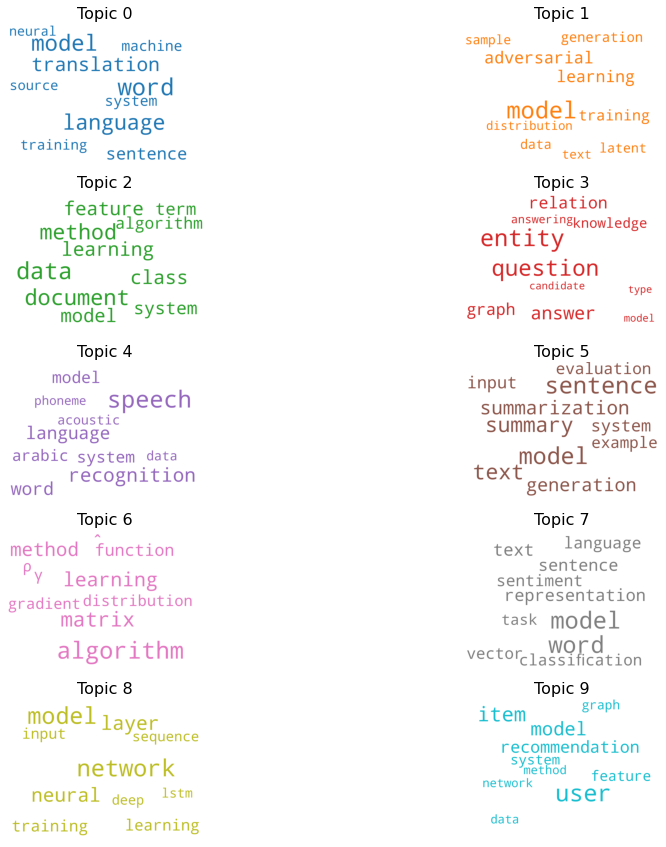

In [274]:
visualize_topic_keywords(lda_10topic, 10)

In [280]:
pyLDAvis_fun(lda_7topic, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.070161  0.058052       1        1  24.588947
6     -0.125756 -0.002956       2        1  22.734029
2     -0.077475 -0.015266       3        1  17.652393
5     -0.026416  0.061543       4        1  15.312109
4     -0.036980  0.122606       5        1  10.172237
1     -0.084218 -0.203820       6        1   8.487869
3      0.421007 -0.020159       7        1   1.052417, topic_info=             Term          Freq         Total Category  logprob  loglift
945          word  29350.000000  29350.000000  Default  30.0000  30.0000
3977    sentiment   4849.000000   4849.000000  Default  29.0000  29.0000
458      language  20517.000000  20517.000000  Default  28.0000  28.0000
2487         user  10477.000000  10477.000000  Default  27.0000  27.0000
883   translation   9146.000000   9146.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1468   expression    147.747320    703.578461   Topic7  -5.5598   2.9934
2014         post    128.892614    419.071611   Topic7  -5.6963   3.3750
2203     semantic    190.652252   4144.031792   Topic7  -5.3048   1.4751
1178     category    135.046215   2015.701796   Topic7  -5.6497   1.8510
298       feature    135.389781  12958.022968   Topic7  -5.6471  -0.0072

[578 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4469       2  0.108128  abstractive
4469       4  0.891122  abstractive
21180      4  0.049833      abusive
21180      7  0.946820      abusive
3197       1  0.158319          acm
...      ...       ...          ...
964        2  0.331342         ﬁrst
964        3  0.060872         ﬁrst
964        4  0.222749         ﬁrst
964        5  0.044348         ﬁrst
964        6  0.101679         ﬁrst

[1348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 6, 5, 2, 4])

# End of Notebook